In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

先將 data load 進來，並做 preprocessing。  
在 $\mathrm{X}$ 中，我們發現 PTS_TYPE 這一個 feature 本身只有兩種值，也就是兩分球或三分球，所以我就把兩分球當作 $0$，三分球當作 $1$ 來考慮。


In [83]:
X = pd.read_csv('./data/nba/X_train.csv')
y = pd.read_csv('./data/nba/y_train.csv')

X['PTS_TYPE'] = np.where(X['PTS_TYPE']==3, 1, 0)
print(X[:4])
print(y[:4])
X_load = X.as_matrix()
y_load = y.as_matrix().squeeze()

   PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
0       2         557        15.5         0         0.7        2.1         0   
1       2         151        20.1         0         0.8        2.7         0   
2       3         448        14.2         0         0.8        5.1         0   
3       1         279        10.6         0         0.6        1.9         0   

   CLOSE_DEF_DIST  
0             0.0  
1             3.4  
2             0.1  
3             2.7  
   FGM
0    1
1    1
2    0
3    1


In [84]:
X5_load = np.hstack((X['GAME_CLOCK'][:, np.newaxis],
                  X['SHOT_DIST'][:, np.newaxis], 
                  X['SHOT_CLOCK'][:, np.newaxis],
                  X['CLOSE_DEF_DIST'][:, np.newaxis],
                  X['TOUCH_TIME'][:, np.newaxis]))

接著把 data 分出 train 和 validation。

In [85]:
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(X_load, y_load, test_size=0.3, random_state=0)

print('# Training data: %d' % X_train.shape[0])
print('# Validation data: %d' % X_val.shape[0])
print('labels: %s' % np.unique(y_val))

# Training data: 36679
# Validation data: 15720
labels: [0 1]


In [86]:
X5_train, X5_val, y5_train, y5_val = train_test_split(X5_load, y_load, test_size=0.3, random_state=0)

將 training 和 validation data 做 z-normalization。

In [87]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)

In [88]:
sc5 = StandardScaler()
sc5.fit(X5_train)
X5_train_std = sc5.transform(X5_train)
X5_val_std = sc5.transform(X5_val)

### How I evaluate my model
對於每個 model，我 train 完後，會利用 validation set 來比對 predict 出來的值，並計算出 accuracy 和 misclassified samples。  
若 model 是 regression，若 predict 出來的結果 $\ge 0.5$，我就取 $1$；反之則取 $0$。

In [89]:
# 準備記錄下每個 model 的 performance
best_model = {}
best_5D_model = {}

# Decision Tree

In [90]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree.fit(X_train_std, y_train)

y_pred = tree.predict(X_val_std)

print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Decision Tree Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['Decision_Tree'] = (y_val != y_pred).sum()

# 5 features
tree5 = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree5.fit(X5_train_std, y5_train)

y5_pred = tree5.predict(X5_val_std)
best_5D_model['Decision_Tree'] = (y5_val != y5_pred).sum()

Misclassified samples: 6036
Decision Tree Accuracy: 0.62


# Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_std, y_train)

y_pred = forest.predict(X_val_std)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Random Forest Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['Random_Forest'] = (y_val != y_pred).sum()

# 5 features
forest5 = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest5.fit(X5_train_std, y5_train)

y5_pred = forest5.predict(X5_val_std)
best_5D_model['Random_Forest'] = (y5_val != y5_pred).sum()

Misclassified samples: 6278
Random Forest Accuracy: 0.60


# Perceptron

In [94]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=30, eta0=0.00001, random_state=0)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_val_std)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['Perceptron'] = (y_val != y_pred).sum()

# 5 features
ppn5 = Perceptron(n_iter=30, eta0=0.00001, random_state=0)
ppn5.fit(X5_train_std, y5_train)

y5_pred = ppn5.predict(X5_val_std)
best_5D_model['Perceptron'] = (y5_val != y5_pred).sum()

Misclassified samples: 6526
Accuracy: 0.58


# Adaline with GD

In [95]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.5, 1, 0)

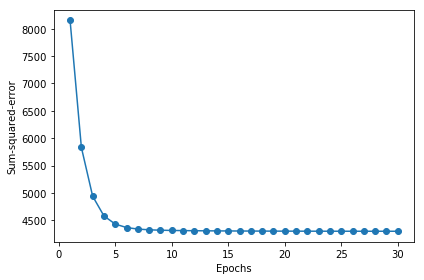

Misclassified samples: 6088
Accuracy: 0.61


In [96]:
ada = AdalineGD(n_iter=30, eta=0.00001)
ada.fit(X_train_std, y_train)

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

y_pred = ada.predict(X_val_std)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['AdalineGD'] = (y_val != y_pred).sum()


# 5 features
ada5 =  AdalineGD(n_iter=30, eta=0.00001)
ada5.fit(X5_train_std, y5_train)

y5_pred = ada5.predict(X5_val_std)
best_5D_model['AdalineGD'] = (y5_val != y5_pred).sum()

# Adaline with SGD

In [97]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.5, 1, 0)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

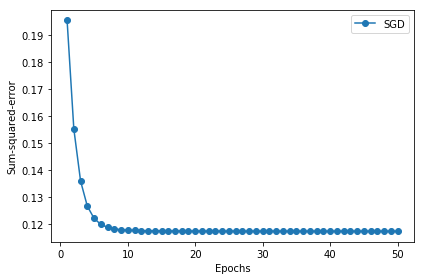

Misclassified samples: 6087
Accuracy: 0.61


In [98]:
adas = AdalineSGD(n_iter=50, eta=0.00001, random_state=0)
adas.fit(X_train_std, y_train)

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# testing accuracy

y_pred = adas.predict(X_val_std)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['AdalineSGD'] = (y_val != y_pred).sum()


# 5 features
adas5 =  AdalineSGD(n_iter=50, eta=0.00001, random_state=0)
adas5.fit(X5_train_std, y5_train)

y5_pred = adas5.predict(X5_val_std)
best_5D_model['AdalineSGD'] = (y5_val != y5_pred).sum()

# Linear Regression

In [99]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
# fit -> training
lr.fit(X_train_std, y_train)

y_pred_tmp = lr.predict(X_val_std)
y_pred = np.where(y_pred_tmp>=0.5, 1, 0)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['LR'] = (y_val != y_pred).sum()

# 5 features
lr5 = LinearRegression()
lr5.fit(X5_train_std, y5_train)

y5_pred_tmp = lr5.predict(X5_val_std)
y5_pre = np.where(y_pred_tmp>=0.5, 1, 0)
best_5D_model['LR'] = (y5_val != y5_pred).sum()

Misclassified samples: 6086
Accuracy: 0.61


# Polynomial Regression

In [100]:
from sklearn.preprocessing import PolynomialFeatures

degree = [2, 3, 5]

for d in degree:
    poly = PolynomialFeatures(degree=d)
    poly5 = PolynomialFeatures(degree=d)
    
    X_train_poly = poly.fit_transform(X_train_std)
    X_val_poly = poly.fit_transform(X_val_std)
    
    X5_train_poly = poly5.fit_transform(X5_train_std)
    X5_val_poly = poly5.fit_transform(X5_val_std)
    # fit features
    poly_r = LinearRegression()
    poly_r.fit(X_train_poly, y_train)
    
    poly_r5 = LinearRegression()
    poly_r5.fit(X5_train_poly, y5_train)
    
    y_pred_tmp = poly_r.predict(X_val_poly)
    y_pred = np.where(y_pred_tmp>=0.5, 1, 0)
    
    y5_pred_tmp = poly_r5.predict(X5_val_poly)
    y5_pred = np.where(y5_pred_tmp>=0.5, 1, 0)
    
    print('Degree: %d' % d)
    print('Misclassified samples: %d' % (y_val != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
    best_model['PR_%d' % d] = (y_val != y_pred).sum()
    
    best_5D_model['PR_%d' % d] = (y5_val != y5_pred).sum()

Degree: 2
Misclassified samples: 5978
Accuracy: 0.62
Degree: 3
Misclassified samples: 5973
Accuracy: 0.62
Degree: 5
Misclassified samples: 6084
Accuracy: 0.61


# Decision Tree Regrssion

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree_r = DecisionTreeRegressor(max_depth=3)
tree_r.fit(X_train_std, y_train)

y_pred_tmp = tree_r.predict(X_val_std)
y_pred = np.where(y_pred_tmp>=0.5, 1, 0)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['Decision_Tree_Regression'] = (y_val != y_pred).sum()

# 5 features
tree_r5 = DecisionTreeRegressor(max_depth=3)
tree_r5.fit(X5_train_std, y5_train)

y5_pred_tmp = tree_r5.predict(X5_val_std)
y5_pre = np.where(y_pred_tmp>=0.5, 1, 0)
best_5D_model['Decision_Tree_Regression'] = (y5_val != y5_pred).sum()

Misclassified samples: 6036
Accuracy: 0.62


# Random Forest Regression

In [102]:
from sklearn.ensemble import RandomForestRegressor

forest_r = RandomForestRegressor(n_estimators=200, criterion='mse', random_state=1, n_jobs=-1)
forest_r.fit(X_train_std, y_train)

y_pred_tmp = forest_r.predict(X_val_std)
y_pred = np.where(y_pred_tmp>=0.5, 1, 0) 

print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
best_model['Random_Forest_Regression'] = (y_val != y_pred).sum()

# 5 features
forest_r5 = RandomForestRegressor(n_estimators=200, criterion='mse', random_state=1, n_jobs=-1)
forest_r5.fit(X5_train_std, y5_train)

y5_pred_tmp = forest_r5.predict(X5_val_std)
y5_pre = np.where(y_pred_tmp>=0.5, 1, 0)
best_5D_model['Random_Forest_Regression'] = (y5_val != y5_pred).sum()

Misclassified samples: 6477
Accuracy: 0.59


# Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(C=100, random_state=0)
logr.fit(X_train_std, y_train)

y_pred = logr.predict(X_val_std)
print('Misclassified samples: %d' % (y_val != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y_val, y_pred))
best_model['Log_Regression'] = (y_val != y_pred).sum()

# 5 features
logr5 = LogisticRegression(C=100, random_state=0)
logr5.fit(X5_train_std, y5_train)

y5_pre = logr5.predict(X5_val_std)
best_5D_model['Log_Regression'] = (y5_val != y5_pred).sum()

Misclassified samples: 6085
Accuracy: 0.61



### Best Model

In [104]:
for k in sorted(best_model, key=best_model.get):
    print('Model: %s, Misclassified: %d' % (k, best_model[k]))

Model: PR_3, Misclassified: 5973
Model: PR_2, Misclassified: 5978
Model: Decision_Tree, Misclassified: 6036
Model: Decision_Tree_Regression, Misclassified: 6036
Model: PR_5, Misclassified: 6084
Model: Log_Regression, Misclassified: 6085
Model: LR, Misclassified: 6086
Model: AdalineSGD, Misclassified: 6087
Model: AdalineGD, Misclassified: 6088
Model: Random_Forest, Misclassified: 6278
Model: Random_Forest_Regression, Misclassified: 6477
Model: Perceptron, Misclassified: 6526


從結果來看， degree = 3 的 polynomial regression 的結果最好，準確率達到 0.62，同時誤判的數量最少，有 5973 個。   
如果只考慮二元分類的 models，表現最佳的是 decision tree。  
其中，Perceptron 表現較差，只有 0.58，我認為原因是這個問題本身的值並非 linear seperable，勉強分開只會令結果普普通通而已。

In [105]:
def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

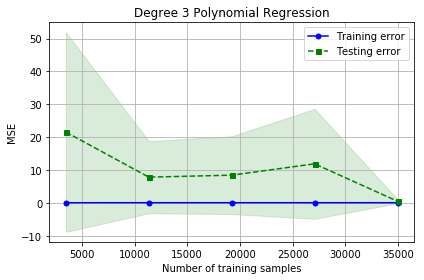

In [106]:
from sklearn.learning_curve import learning_curve

sc_load = StandardScaler()
sc_load.fit_transform(X_load)
X_load_std = sc_load.transform(X_load)

poly = PolynomialFeatures(degree=3)
X_load_poly = poly.fit_transform(X_load_std)

poly_regr = LinearRegression()


train_sizes, train_scores, test_scores = learning_curve(
estimator=poly_regr, X=X_load_poly, y=y_load, scoring=mse)



train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
      train_sizes,
      train_mean,
      color='blue',
      marker='o',
      markersize=5,
      label='Training error')
plt.fill_between(
      train_sizes,
      train_mean + train_std,
      train_mean - train_std,
      alpha=0.15,
      color='blue')

plt.plot(
      train_sizes,
      test_mean,
      color='green',
      linestyle='--',
      marker='s',
      markersize=5,
      label='Testing error')
plt.fill_between(
      train_sizes,
      test_mean + test_std,
      test_mean - test_std,
      alpha=0.15,
      color='green')

plt.title('Degree %d Polynomial Regression' % 3)
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


從 learning curve 能發現，當 data 少的時候，testing error 遠高於 training error。  
但隨著 training samples 增加，testing error 就會漸漸下滑，最後和 training error 逐漸接近並收斂。  
自始至終，testing error 都高於 training error。  
因此，我認為沒有 overfitting。

 1) GAME_CLOCK                     0.200453
 2) SHOT_DIST                      0.200179
 3) SHOT_CLOCK                     0.177025
 4) CLOSE_DEF_DIST                 0.173898
 5) TOUCH_TIME                     0.140622
 6) PERIOD                         0.052434
 7) DRIBBLES                       0.048234
 8) PTS_TYPE                       0.007156


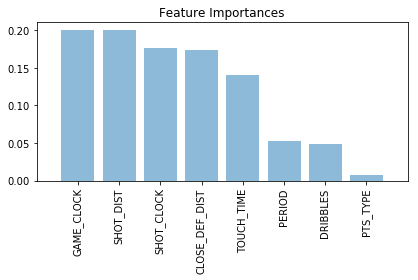

In [107]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train_std.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train_std.shape[1]])
plt.tight_layout()
plt.show()

我使用了 random forests 的 feature importance 來挑 features。  
最後能發現 **GAME_CLOCK、SHOT_DIST、SHOT_CLOCK** 這三個的重要性比較高。  
接著我們就只用這三個 features 來試試看 accuracy。

In [108]:
X_3D = np.hstack((X['GAME_CLOCK'][:, np.newaxis],
                  X['SHOT_DIST'][:, np.newaxis], 
                  X['SHOT_CLOCK'][:, np.newaxis]))
y_3D = y
print('#Features: %d' % X_3D.shape[1])
print(X_3D[:4])
print(y_3D[:4])


#Features: 3
[[ 557.     2.1   15.5]
 [ 151.     2.7   20.1]
 [ 448.     5.1   14.2]
 [ 279.     1.9   10.6]]
   FGM
0    1
1    1
2    0
3    1


In [109]:
X3_train, X3_val, y3_train, y3_val = train_test_split(X_3D, y_3D, test_size=0.3, random_state=0)
print('#Training data: %d' % X3_train.shape[0])
print('#Validation data: %d' % X3_val.shape[0])

#Training data: 36679
#Validation data: 15720


In [110]:
sc3 = StandardScaler()
sc3.fit(X3_train)

X3_train_std = sc3.transform(X3_train)
X3_val_std = sc3.transform(X3_val)

In [111]:
poly = PolynomialFeatures(degree=3)

X3_train_poly = poly.fit_transform(X3_train_std)
X3_val_poly = poly.fit_transform(X3_val_std)

poly_regr = LinearRegression()
poly_regr.fit(X3_train_poly, y3_train)

y_pred_tmp = poly_regr.predict(X3_val_poly)
y_pred = np.where(y_pred_tmp >= 0.5, 1, 0)
print('Misclassified samples: %d' % (y3_val != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y3_val, y_pred))

Misclassified samples: 6125
Accuracy: 0.61



最後的結果會比原先差，但是差距並不是很大。  
結果比較差的原因，我認為是**因為我們丟掉了數個 features，其中包括了一些 importance 不低的 features**，雖然成功降低了維度，但是卻也丟掉了一些能拿來學習的資料。  

接著，我想試試看，若我留下影響力**最高的 5 個 features**，也就是先前的三個加上 CLOSE_DEF_DIST 和 TOUCH_TIME ，會有怎樣的結果。  
之所以會選擇 5 個，是因為前五名的影響力遠高於剩下的。

In [112]:
print('#Features: %d' % X_5D.shape[1])
y_5D = y.squeeze()

#Features: 5


In [113]:
print('#Training data: %d' % X5_train.shape[0])
print('#Validation data: %d' % X5_val.shape[0])

#Training data: 36679
#Validation data: 15720


In [115]:
poly = PolynomialFeatures(degree=3)

X5_train_poly = poly.fit_transform(X5_train_std)
X5_val_poly = poly.fit_transform(X5_val_std)

poly_regr = LinearRegression()
poly_regr.fit(X5_train_poly, y5_train)

y_pred_tmp = poly_regr.predict(X5_val_poly)
y_pred = np.where(y_pred_tmp >= 0.5, 1, 0)
print('Misclassified samples: %d' % (y5_val != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y5_val, y_pred))

Misclassified samples: 5928
Accuracy: 0.62



拿出影響力最高的 5 個後，竟然發現結果比原先的好了一點，misclassified samples 從 5973 個稍微降低到 5928 個。  
會有這樣的結果，我認為原因是被我們丟掉的那些 features 本身對於 training 的幫助有限，甚至會 learn 到一些效果不彰的 patterns，造成結果反而變差。  
為了瞭解這是不是單純的運氣好，我決定再做一次實驗，這次的 X 只保留了 5 個影響力最高的 features，並把這個 5 個維度的 X 再拿去每個 model train 一次。


In [116]:
print('# Features: %d' % X_5D.shape[1])
for k in sorted(best_model, key=best_5D_model.get):
    print('Model: %s, Misclassified: %d' % (k, best_5D_model[k]))
print('\n# Features: %d' % X_load.shape[1])
for k in sorted(best_model, key=best_model.get):
    print('Model: %s, Misclassified: %d' % (k, best_model[k]))

# Features: 5
Model: PR_3, Misclassified: 5928
Model: PR_5, Misclassified: 5963
Model: Decision_Tree_Regression, Misclassified: 5963
Model: Random_Forest_Regression, Misclassified: 5963
Model: Log_Regression, Misclassified: 5963
Model: PR_2, Misclassified: 5966
Model: Decision_Tree, Misclassified: 6036
Model: AdalineGD, Misclassified: 6099
Model: AdalineSGD, Misclassified: 6103
Model: LR, Misclassified: 6103
Model: Random_Forest, Misclassified: 6370
Model: Perceptron, Misclassified: 6588

# Features: 8
Model: PR_3, Misclassified: 5973
Model: PR_2, Misclassified: 5978
Model: Decision_Tree, Misclassified: 6036
Model: Decision_Tree_Regression, Misclassified: 6036
Model: PR_5, Misclassified: 6084
Model: Log_Regression, Misclassified: 6085
Model: LR, Misclassified: 6086
Model: AdalineSGD, Misclassified: 6087
Model: AdalineGD, Misclassified: 6088
Model: Random_Forest, Misclassified: 6278
Model: Random_Forest_Regression, Misclassified: 6477
Model: Perceptron, Misclassified: 6526


從結果來看，會發現 **Regression 的方法大部分會因此受惠**。

最後，我把我最後選的 Degree=3 的 Polynomial Regression 和 這個 feature selection 的結果，應用到 X_test 上。

In [128]:
X_test_load = pd.read_csv('./data/nba/X_test.csv')

In [129]:
X_test = np.hstack((X_test_load['GAME_CLOCK'][:, np.newaxis],
                    X_test_load['SHOT_DIST'][:, np.newaxis], 
                    X_test_load['SHOT_CLOCK'][:, np.newaxis],
                    X_test_load['CLOSE_DEF_DIST'][:, np.newaxis],
                    X_test_load['TOUCH_TIME'][:, np.newaxis]))

print('# Features: %d' % X_test.shape[1])
print('# Testing Samples: %d' % X_test.shape[0])

print(X_test[:4])

# Features: 5
# Testing Samples: 13100
[[ 220.    18.5   13.3   10.5   10.1]
 [   2.    25.1    0.     5.8    1.3]
 [ 375.     5.2   22.1    1.6    2.7]
 [ 597.     8.1   15.2    3.3    8.6]]


In [130]:
sc_final = StandardScaler()
sc_final.fit(X5_load)

X5_std = sc_final.transform(X5_load)
X5_test_std = sc_final.transform(X_test)

In [137]:
poly = PolynomialFeatures(degree=3)

X5_train_poly = poly.fit_transform(X5_std)
X5_test_poly = poly.fit_transform(X5_test_std)

poly_regr = LinearRegression()
poly_regr.fit(X5_train_poly, y_load)

y_pred_tmp = poly_regr.predict(X5_test_poly)
y_pred_final = np.where(y_pred_tmp >= 0.5, 1, 0)
print(y_pred_final[:10])

[0 0 0 0 1 1 0 0 1 0]


In [142]:
import csv
prediction = pd.DataFrame(y_pred_final, columns=['y_pred'])
out = prediction.to_csv('y_pred.csv')
print(prediction[:10])

   y_pred
0       0
1       0
2       0
3       0
4       1
5       1
6       0
7       0
8       1
9       0
